TRAIN_DIR: C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


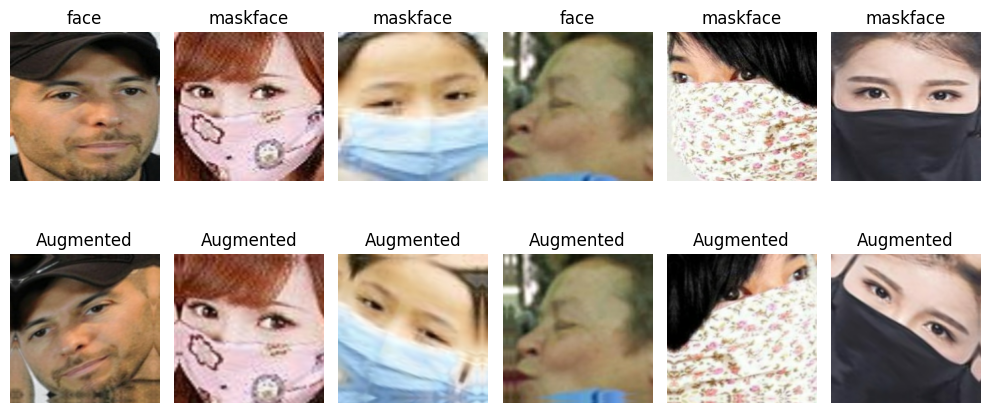

In [1]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

# Modèle 3 (VGG16 amélioré & Fine-Tuning)

Dans cette cellule, on construit une version **améliorée** du modèle VGG16 avec **fine-tuning partiel**, régularisation et une tête de classification plus profonde.

---

### 🔹 1. Déblocage partiel de VGG16 (Fine-Tuning)

- `block4` et `block5` sont rendus **trainables**,  
- les blocs précédents restent gelés pour conserver les features génériques d’ImageNet.

🎯 **Objectif :**  
Adapter les couches haut-niveau (celles qui capturent les formes complexes) à notre dataset *face / maskface*, sans détruire ce que VGG16 a déjà appris.

C’est un compromis idéal entre :
- stabilité (couches profondes gelées),
- et flexibilité (fine-tuning des couches spécialisées).

---

### 🔹 2. Pipeline d’entrée

- `data_augmentation` pour enrichir automatiquement les données,
- `Rescaling(1./255)` pour normaliser les images dans [0,1].

---

### 🔹 3. Tête de classification améliorée

La tête est nettement plus robuste que dans les modèles précédents :

- `GlobalAveragePooling2D`
- **Dense(512, relu) + L2 regularization**
- **BatchNormalization** → stabilise l’entraînement
- **Dropout(0.5)** → limite l’overfitting
- **Dense(128, relu) + L2 + Dropout(0.3)**
- `Dense(1, sigmoid)` → sortie binaire

 **Objectif de la tête améliorée :**
- forcer le réseau à apprendre des représentations plus compactes mais robustes,
- réduire les oscillations du fine-tuning,
- mieux séparer les visages masqués / non masqués.

---

### 🔹 4. Résultat attendu

Ce modèle combine :
- la puissance de VGG16 pré-entraîné,
- le fine-tuning des couches spécialisées,
- une tête dense moderne avec régularisation.

’est normalement le **modèle le plus performant** parmi les VGG testés, ce qui sera confirmé dans les métriques et les courbes d’apprentissage.


In [5]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

# Base VGG16
base_model4 = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# On débloque seulement les derniers blocs pour le fine-tuning
trainable = False
for layer in base_model4.layers:
    if "block5" in layer.name or "block4" in layer.name:
        trainable = True
    layer.trainable = trainable

print("Nombre de couches trainables :", len([l for l in base_model4.layers if l.trainable]))

# Tête de classification améliorée
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model4(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(
    512,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_vgg4 = keras.Model(inputs, outputs, name="vgg16_finetuned")

model_vgg4.summary()


Nombre de couches trainables : 8
Model: "vgg16_finetuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)    

## Compilation + callbacks (Modèle 4)

On utilise :
- Adam avec un **learning rate plus petit** (1e-4) pour le fine-tuning,
- binary_crossentropy,
- accuracy, precision, recall,
- sauvegarde du meilleur modèle,
- EarlyStopping + ReduceLROnPlateau.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_vgg4.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
)

checkpoint_vgg4 = ModelCheckpoint(
    "models/vgg16_finetuned_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop_vgg4 = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_vgg4 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)


## Entraînement du Modèle 3 (VGG16 amélioré)


In [7]:
history_vgg4 = model_vgg4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint_vgg4, early_stop_vgg4, reduce_lr_vgg4],
    verbose=1
)

Epoch 1/25
298/298 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8732 - precision: 0.8480 - recall: 0.9067
Epoch 1: val_loss improved from inf to 0.50805, saving model to models\vgg16_finetuned_best.h5
298/298 [==============================] - 103s 273ms/step - loss: 0.3802 - accuracy: 0.8732 - precision: 0.8480 - recall: 0.9067 - val_loss: 0.5080 - val_accuracy: 0.9108 - val_precision: 0.9793 - val_recall: 0.8455 - lr: 1.0000e-04
Epoch 2/25
298/298 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9161 - precision: 0.9131 - recall: 0.9181
Epoch 2: val_loss did not improve from 0.50805
298/298 [==============================] - 78s 263ms/step - loss: 0.2755 - accuracy: 0.9161 - precision: 0.9131 - recall: 0.9181 - val_loss: 1.5907 - val_accuracy: 0.5640 - val_precision: 0.5428 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 3/25
298/298 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9319 - precision: 0.9313 - recall:

## Courbes Loss & Accuracy (Modèle 4)


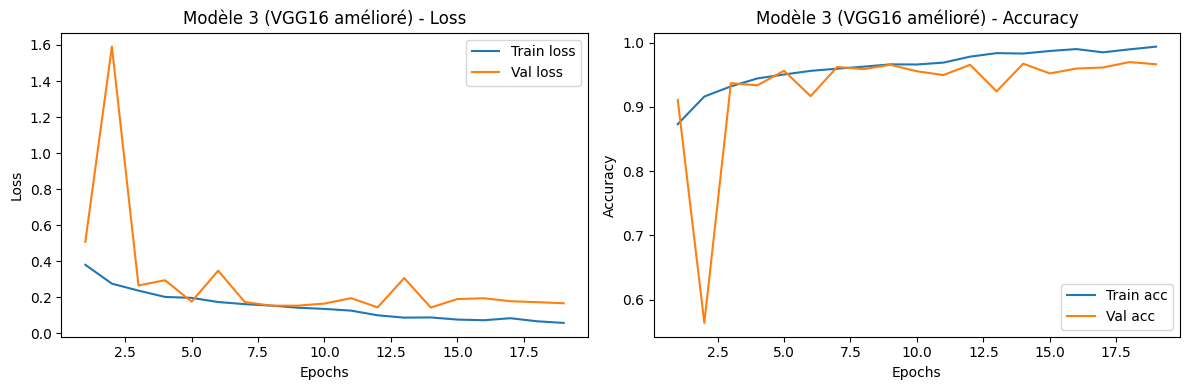

In [8]:
from load import plot_history
plot_history(history_vgg4, title_prefix="Modèle 3 (VGG16 amélioré)")

## Évaluation sur le test (Modèle 3)


In [9]:
test_results_vgg4 = model_vgg4.evaluate(test_ds, verbose=1)

print("\nRésultats Modèle 3 (VGG16 amélioré) :")
for name, value in zip(model_vgg4.metrics_names, test_results_vgg4):
    print(f"{name}: {value:.4f}")


192/192 [==============================] - 20s 100ms/step - loss: 0.2161 - accuracy: 0.9507 - precision: 0.8938 - recall: 0.9702

Résultats Modèle 3 (VGG16 amélioré) :
loss: 0.2161
accuracy: 0.9507
precision: 0.8938
recall: 0.9702


##  Matrice de confusion et rapport de classification (Modèle 3)

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

y_pred_proba = model_vgg4.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


192/192 [==============================] - 17s 88ms/step
Confusion Matrix:
 [[1899  120]
 [  31 1010]]

Classification Report:
              precision    recall  f1-score   support

        face       0.98      0.94      0.96      2019
    maskface       0.89      0.97      0.93      1041

    accuracy                           0.95      3060
   macro avg       0.94      0.96      0.95      3060
weighted avg       0.95      0.95      0.95      3060



### Interprétation des courbes – Modèle 3 (VGG16 amélioré & fine-tuning)

Les graphiques montrent clairement l’effet positif du **fine-tuning des blocs 4 et 5 de VGG16**, combiné à une tête de classification plus riche (BatchNorm, régularisation L2, Dropout).

---

### 🔹 Analyse de la courbe **Loss**

- **Loss d’entraînement**  
  - Elle baisse rapidement et devient très faible dès les premiers epochs.  
  - Le modèle apprend efficacement grâce aux couches débloquées et à la tête dense plus profonde.

- **Loss de validation**
  - Quelques oscillations au début (normal pendant le fine-tuning).  
  - Elle finit par se stabiliser autour de valeurs basses, **sans divergence** → pas d’overfitting critique.
  - Le pic très haut au début est typique du fine-tuning : les poids pré-entraînés sont encore en phase d’adaptation.

🧠 **Conclusion :** Le modèle apprend bien et reste stable. Le fine-tuning est maîtrisé.

---

### 🔹 Analyse de la courbe **Accuracy**

- **Accuracy d’entraînement**
  - Monte régulièrement jusqu’à **≈ 99 %** → très bonne capacité d’apprentissage.
- **Accuracy de validation**
  - Forte variation au 2ᵉ epoch (instabilité initiale).
  - Puis elle se stabilise entre **94 % et 96 %**, très proche de la courbe d’entraînement.
  - La validation suit bien le train → le modèle généralise correctement.

🧠 **Conclusion :** Le modèle est plus performant que les versions précédentes et ne souffre pas d’overfitting marqué.

---

### 🔹 Conclusion générale sur les courbes

- Le **fine-tuning des derniers blocs** améliore nettement l’apprentissage.
- Les **oscillations initiales** sont normales car les poids ImageNet doivent s’adapter.
- Les deux courbes (train/val) restent rapprochées, indiquant une bonne **généralisation**.
- La stabilité progressive et la haute accuracy montrent que ce modèle est **le meilleur des trois** jusqu’ici.

Ces tendances se confirment dans les métriques finales :  
**accuracy = 95.07 %, recall = 97 %, f1 élevés → modèle très solide.**
